In [1]:
import itertools
import logging
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq 

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
#from pandas.tseries.offsets import DateOffset

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

warnings.filterwarnings("ignore")
logger = logging.getLogger()
#logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.ERROR)


/Users/evan/.pyenv/versions/3.11.5/envs/de/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def query_ticker_data():
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_by_month`
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [3]:
all = query_ticker_data().set_index('date')

In [4]:
apple = all[all['ticker'] == 'AAPL']
netflix = all[all['ticker'] == 'NFLX']
microsoft = all[all['ticker'] == 'MSFT']
amazon = all[all['ticker'] == 'AMZN']
alphabet = all[all['ticker'] == 'GOOGL']
coke = all[all['ticker'] == 'KO']

In [5]:
apple.name = "Apple"
netflix.name = "Netflix"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [23]:
TARGET_DF = alphabet

In [24]:
vwap = TARGET_DF['volume_weighted_average_price']

In [25]:
TARGET_DF['simple_rtn'] = vwap.pct_change()
TARGET_DF['log_rtn'] = np.log(vwap/vwap.shift(1))

[Text(0, 0.5, 'Simple returns (%)')]

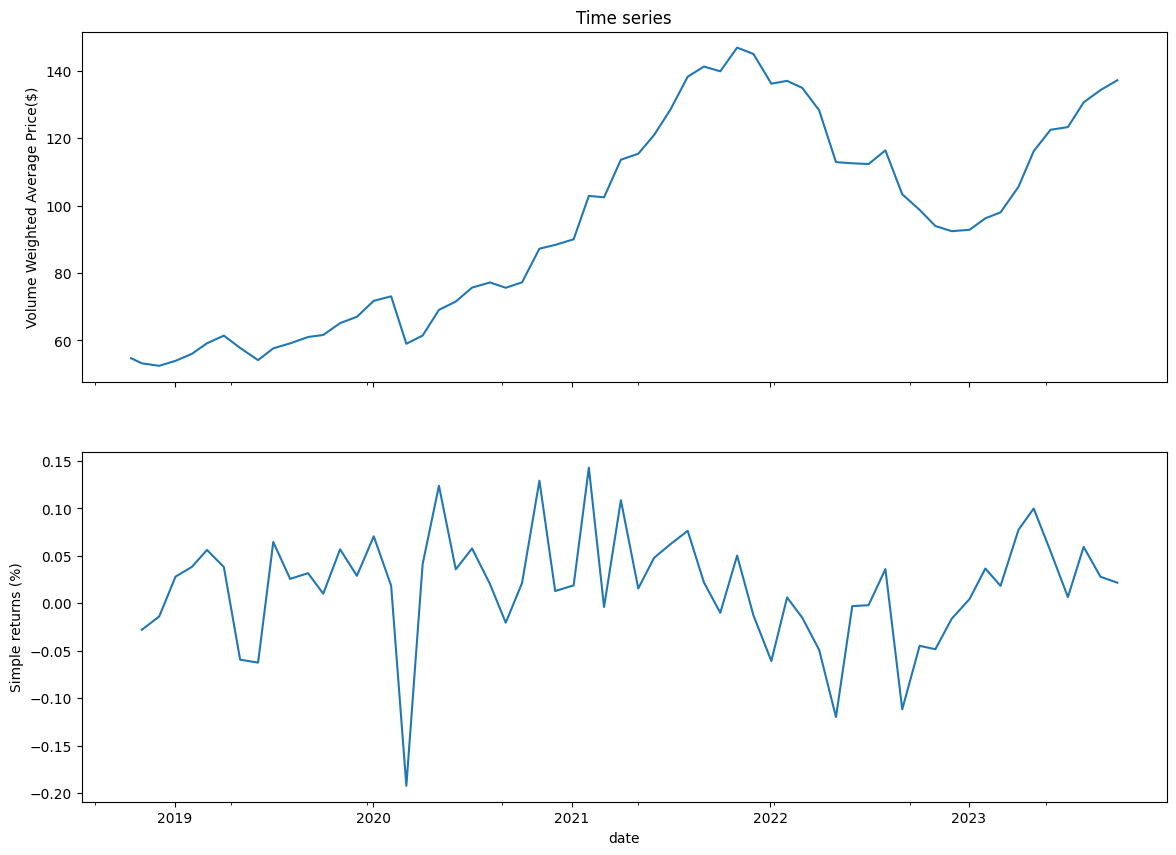

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Volume Weighted Average Price($)')
TARGET_DF.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

In [27]:
hist = TARGET_DF[['volume_weighted_average_price']]
hist.reset_index(level=0, inplace=True)
hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

In [28]:
param_grid = { 
    "daily_seasonality": [False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [False, True],
    "growth": ["linear"],
    "seasonality_mode": ["additive", "multiplicative"],    
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    #m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
    #m.add_country_holidays("US")
    m = m.fit(hist)  # Fit model with given params
    df_cv = cross_validation(m, initial='1095 days', period='63 days', horizon = '252 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] start processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:22 - cmdstanpy - INFO - Chain [1] done processing
12:41:24 - cmdstanpy - INFO - Chain [1]

,daily_seasonality,weekly_seasonality,yearly_seasonality,growth,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,rmse
0,False,False,False,linear,additive,0.001,0.01,38.699174
1,False,False,False,linear,additive,0.001,0.10,38.699174
2,False,False,False,linear,additive,0.001,1.00,38.699174
3,False,False,False,linear,additive,0.001,10.00,38.699174
4,False,False,False,linear,additive,0.010,0.01,39.108273
...,...,...,...,...,...,...,...,...
59,False,False,True,linear,multiplicative,0.100,10.00,44.094126
60,False,False,True,linear,multiplicative,0.500,0.01,40.664554
61,False,False,True,linear,multiplicative,0.500,0.10,35.755472
62,False,False,True,linear,multiplicative,0.500,1.00,35.746998


In [29]:
# Python
best_params = all_params[np.argmin(rmses)]
best_params

{'daily_seasonality': False,
 'weekly_seasonality': False,
 'yearly_seasonality': True,
 'growth': 'linear',
 'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 1.0}

12:45:02 - cmdstanpy - INFO - Chain [1] start processing
12:45:03 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
            ds        yhat  yhat_lower  yhat_upper
317 2024-09-25  150.942593  123.242189  178.672971
318 2024-09-26  153.364142  126.666552  182.755481
319 2024-09-27  155.652601  128.352583  184.587722
320 2024-09-30  161.337706  132.804221  190.031865
321 2024-10-01  162.744720  134.867560  191.494955


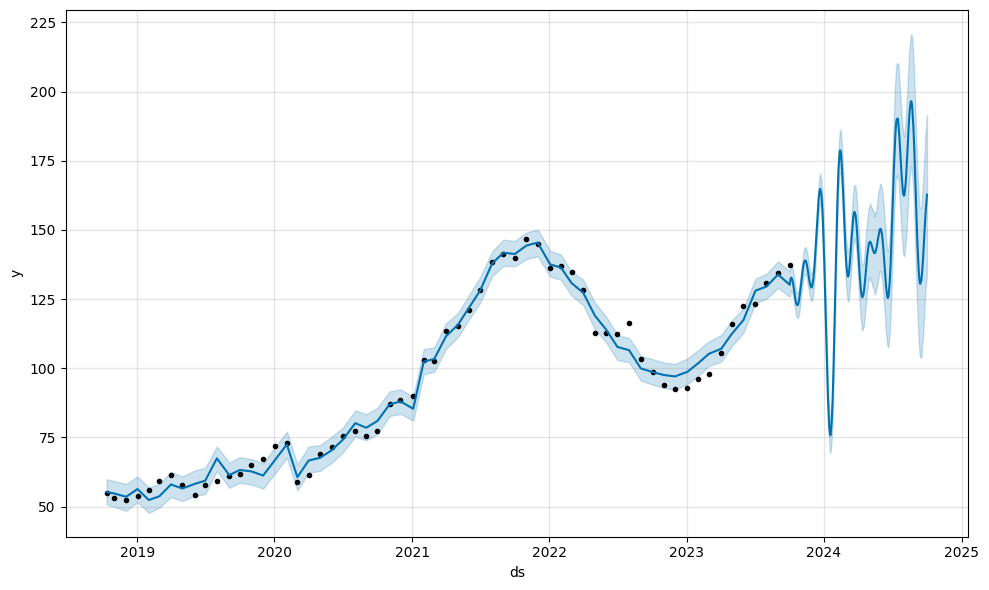

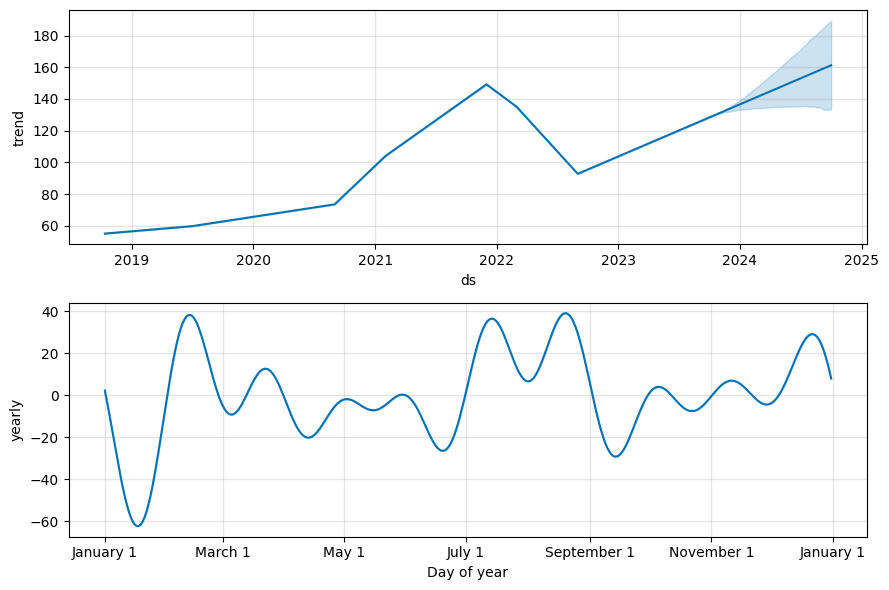

In [30]:
"""
param ={
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "growth": "linear",
    "seasonality_mode": "additive",
    'changepoint_prior_scale': 0.01, 
    'seasonality_prior_scale': 10.0
}
"""

m = Prophet(**best_params)
#m= m.add_seasonality(name="monthly", period=30, fourier_order=10)
#m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
#m.add_country_holidays("US")
m.fit(hist)
future = m.make_future_dataframe(periods=365, freq='D')
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
print("Predicted Data")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

#plot_plotly(m, forecast, figsize=(1000,600)) # 
#plot_components_plotly(m, forecast, figsize=(1000,600))

In [31]:
df_cv = cross_validation(m, initial='1095 days', period='90 days', horizon = '365 days', parallel="processes")

12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] done processing
12:45:04 - cmdstanpy - INFO - Chain [1] done processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,79.156405,8.896989,6.414260,0.057152,0.042345,0.055106,0.500
1,30 days,89.855953,9.479238,7.530675,0.069363,0.066767,0.066727,0.250
2,55 days,69.085623,8.311776,7.240635,0.064284,0.066767,0.063193,0.375
3,57 days,101.217326,10.060682,9.240956,0.082111,0.066767,0.079831,0.250
4,59 days,89.824018,9.477553,7.808009,0.070101,0.063200,0.067361,0.500
5,60 days,83.002680,9.110581,7.226071,0.064115,0.051229,0.061734,0.500
6,86 days,70.864875,8.418128,5.499006,0.051322,0.030775,0.048598,0.500
7,87 days,108.621631,10.422170,6.536069,0.060626,0.030775,0.056562,0.500
8,91 days,117.789232,10.853075,7.797778,0.073529,0.056581,0.069008,0.500
9,93 days,113.228356,10.640881,7.112039,0.066086,0.041695,0.061936,0.750


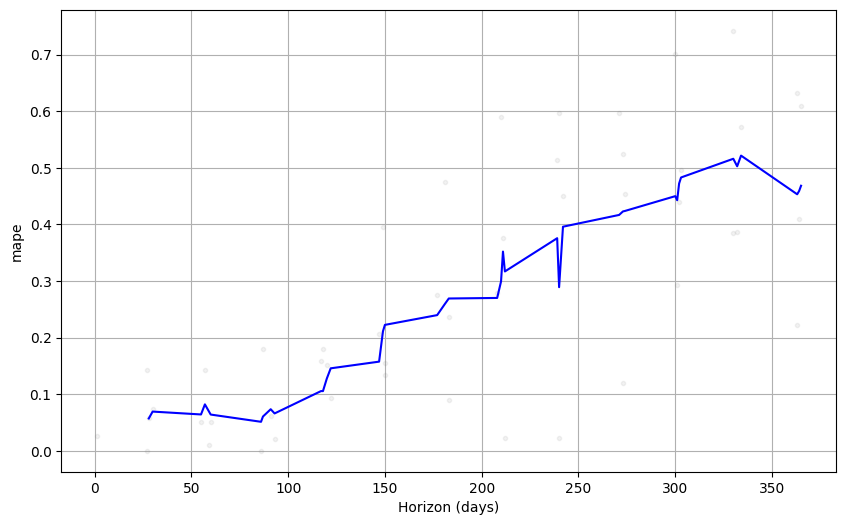

In [33]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [34]:
duckdb.sql("select cutoff, count(*) from df_cv group by 1 order by 1").df()

,cutoff,count_star()
0,2022-01-05,12
1,2022-04-05,12
2,2022-07-04,12
3,2022-10-02,13


In [35]:
df_cv[df_cv.cutoff=="2022-10-02"]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
36,2022-10-03,101.308469,98.635687,103.887534,98.749376,2022-10-02
37,2022-11-01,100.988895,97.804092,104.127687,93.964143,2022-10-02
38,2022-12-01,97.124422,93.349201,101.396084,92.427424,2022-10-02
39,2023-01-03,90.891230,85.493096,97.284335,92.845275,2022-10-02
40,2023-02-01,87.298857,79.614900,95.571775,96.246726,2022-10-02
41,2023-03-01,84.880205,75.309321,95.954465,98.012670,2022-10-02
42,2023-04-03,80.557250,68.515653,94.019960,105.600132,2022-10-02
43,2023-05-01,72.576810,57.714602,88.865426,116.151577,2022-10-02
44,2023-06-01,67.282265,49.540839,86.267158,122.517933,2022-10-02
45,2023-07-03,67.333449,47.324686,89.750367,123.316635,2022-10-02


In [36]:
def mape( actuals, forecast ):
  x = 0
  for i in range( actuals.index.min(), actuals.index.max()+1 ):
    x += np.abs( ( actuals[i] - forecast[i] ) / actuals[i] )
  return x / len( actuals )

# Ensure out dataframes have only corresponding entries.
forecast = forecast_df[ forecast_df['ds'].isin( actuals_df['ds'] ) ]
actuals = actuals_df[ actuals_df['ds'].isin( forecast['ds'] ) ]

# Use our MAPE function to evaluate the success of our 60 day forecast.
mape = round( 100 * mape( actuals['y'], forecast['yhat'] ), 2 )
print( f'Forecast MAPE: %' )

NameError: name 'forecast_df' is not defined